In [1]:
import pandas as pd

train_data = pd.read_csv("./Analyzer/sentiment analysis training dataset.csv")
test_data = pd.read_csv("./Analyzer/sentiment analysis test dataset.csv")

train_data와 test_data를 pandas의 read_csv를 활용하여 dataframe으로 불러옵니다.

그 다음 matplotlib을 활용하여 -1, 0, 1 라벨별로 각각 몇개의 데이터가 존재하는지 확인해봅니다.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

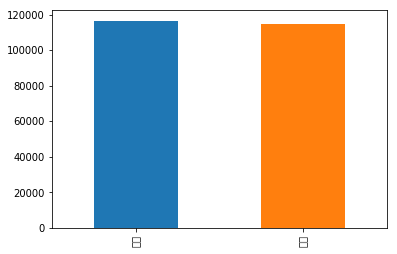

In [3]:
train_data['label'].value_counts().plot(kind='bar')

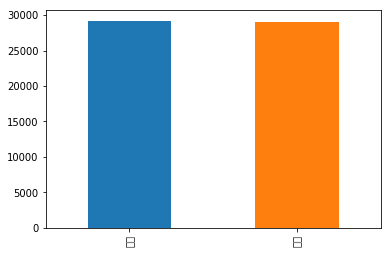

In [4]:
test_data['label'].value_counts().plot(kind='bar')

숫자로도 확인해봅니다. 1이 긍정 -1이 부정 0이 중립입니다.

In [5]:
print(train_data.groupby('label').size().reset_index(name='count'))
print(test_data.groupby('label').size().reset_index(name='count'))

  label   count
0    긍정  116507
1    부정  114822
  label  count
0    긍정  29207
1    부정  29044


3. 모델을 만들기 위한 데이터 전처리 작업
먼저 각각의 제목을 토큰화 해주었습니다.

Okt형태소 분석기를 활용하였습니다.

In [6]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [7]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
X_train = []
for sentence in train_data['title']:
  temp_X = []
  temp_X = okt.morphs(str(sentence), stem=True) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  X_train.append(temp_X)

X_test = []
for sentence in test_data['title']:
  temp_X = []
  temp_X = okt.morphs(str(sentence), stem=True) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  X_test.append(temp_X)

토큰화가 잘 되었는지 출력해보면 다음과 같습니다.

토큰화 한 단어를 컴퓨터가 인식할 수 있도록 정수인코딩을 해주었습니다.

In [8]:
from keras.preprocessing.text import Tokenizer
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [9]:
file=open('Tokenizer for sentiment analysis','wb')
import pickle
pickle.dump(tokenizer,file)
file.close()

데이터의 최대길이 평균길이 그리고 길이를 기준으로 데이터의 분포가 어떠한지 확인해 보았습니다.

In [ ]:
print("제목의 최대 길이 : ", max(len(l) for l in X_train))
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [ ]:
print("제목의 최대 길이 : ", max(len(l) for l in X_test))
print("제목의 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

값으로 들어갈 label -1, 0, 1을 컴퓨터가 보고 알수 있도록 one-hot encoding을 해주었습니다.

In [ ]:
import numpy as np

y_train = []
y_test = []



for i in range(len(train_data['label'])):
  if train_data['label'].iloc[i] == '긍정':
    y_train.append([1, 0])
  elif train_data['label'].iloc[i] == '부정':
    y_train.append([0, 1])
    
for i in range(len(test_data['label'])):
    if test_data['label'].iloc[i] == '긍정':
      y_test.append([0, 0])
    elif test_data['label'].iloc[i] == '부정':
      y_test.append([0, 1])
      
y_train = np.array(y_train)
y_test = np.array(y_test)

4. 모델 만들기

In [ ]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
max_len = 20 # 전체 데이터의 길이를 20로 맞춘다

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

먼저 필요한 것들을 import 해주고 pad_sequences를 활용하여 모든 데이터의 길이를 20으로 통일하였습니다.

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1, batch_size=10, validation_split=0.1)

긍정, 부정, 중립 3가지로 분류해야하니 LSTM, softmax, categorical_crossentropy를 사용하였습니다.

batch_size는 10 6,000개의 훈련데이터 중 10퍼센트인 600개는 validation_data로 활용하기위해 validation_split을 0.1을 부여하였습니다.

optimizer는 rmsprop을 사용하여 위와 같이 모델을 만들고 학습을 시켜보았습니다.

맘스터치관련 기사 제목 1,000개로 구성되어있는 테스트 데이터셋으로 평가해보니 94.27퍼센트가 나왔습니다.

생각보다 너무 잘나와서 조금 이상하지만 optimizer만 adam으로 바꿔 한번 더 해보았습니다.

이번엔 96.07%라는 결과가 나왔습니다.

In [ ]:
model.save('sentiment analysis model')

In [ ]:
predict = model.predict(X_test)

In [ ]:
import numpy as np
predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)

In [ ]:
 for i in range(len(X_test)):
    
    if original_labels[i] == 0:
        original = "긍정"
    elif original_labels[i] == 1:
        original = "부정"
    
    if predict_labels[i] == 0:
        prediction = "긍정"
    elif predict_labels[i] == 1:
        prediction = "부정"
        
    print("기사제목 : ", test_data['title'].iloc[i], "/\t 원래 라벨 : ", original, "/\t예측한 라벨 : ", prediction)
    print()